In [ ]:
# -*- coding: utf-8 -*-
"""
Example pipeline code for 
1) AggMap multi-channel Fmaps transformation; 
2) AggMapNet model traininng, validation;
3) AggModel explainations using Shap and Simp values.
"""

from sklearn.datasets import load_breast_cancer
from aggmap import AggMap, AggMapNet
import pandas as pd

# Data loading
data = load_breast_cancer()
dfx = pd.DataFrame(data.data, columns=data.feature_names)
dfy = pd.get_dummies(pd.Series(data.target))

# AggMap object definition, fitting, and saving 
mp = AggMap(dfx, metric = 'correlation')
mp.fit(cluster_channels=5, emb_method = 'umap', verbose=0)
mp.save('agg.mp')

# AggMap visulizations: Hierarchical tree, embeddng scatter and grid
mp.plot_tree()
mp.plot_scatter()
mp.plot_grid()

# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
y = dfy.values

# AggMapNet training, validation, early stopping, and saving
clf = AggMapNet.MultiClassEstimator(epochs=50, gpuid=0)
clf.fit(X, y, X_valid=None, y_valid=None)
clf.save_model('agg.model')

# Model explaination by simply-explainer: global, local
simp_explainer = AggMapNet.simply_explainer(clf, mp)
global_simp_importance = simp_explainer.global_explain(clf.X_, clf.y_)
local_simp_importance = simp_explainer.local_explain(clf.X_[[0]], clf.y_[[0]])

# Model explaination by shapley-explainer: global, local
shap_explainer = AggMapNet.shapley_explainer(clf, mp)
global_shap_importance = shap_explainer.global_explain(clf.X_)
local_shap_importance = shap_explainer.local_explain(clf.X_[[0]])


2021-10-03 02:57:15,606 - INFO - [bidd-aggmap] - Calculating distance ...
2021-10-03 02:57:15,608 - INFO - [bidd-aggmap] - the number of process is 16


100%|##################################################################################| 30/30 [00:00<00:00, 813.07it/s]


2021-10-03 02:57:16,161 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...


  0%|                                                                                           | 0/569 [00:00<?, ?it/s]

2021-10-03 02:57:19,044 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-10-03 02:57:19,051 - INFO - [bidd-aggmap] - Finished
2021-10-03 02:57:19,118 - INFO - [bidd-aggmap] - generate file: ./feature points_30_correlation_umap_scatter
2021-10-03 02:57:19,125 - INFO - [bidd-aggmap] - save html file to ./feature points_30_correlation_umap_scatter
2021-10-03 02:57:19,126 - INFO - [bidd-aggmap] - generate file: ./feature points_30_correlation_umap_mp
2021-10-03 02:57:19,131 - INFO - [bidd-aggmap] - save html file to ./feature points_30_correlation_umap_mp


100%|################################################################################| 569/569 [00:03<00:00, 188.53it/s]
2021-10-03 02:57:22.490715: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-03 02:57:23.190791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30997 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2021-10-03 02:57:23.938676: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-03 02:57:25.071556: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
  0%|           

saving model to agg.model
2021-10-03 02:57:42,835 - INFO - [bidd-aggmap] - calculating feature importance for class 0 ...


  0%|                                                                                            | 0/30 [00:00<?, ?it/s]

2021-10-03 02:57:44,534 - INFO - [bidd-aggmap] - calculating feature importance for class 1 ...


100%|####################################################################################| 1/1 [00:00<00:00, 698.58it/s]



  0%|                                                                                             | 0/1 [00:00<?, ?it/s]


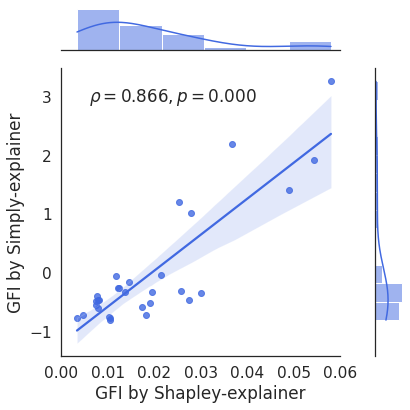

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


sns.set(font_scale=1.4, style='white')
a = global_shap_importance.shapley_importance_class_1.tolist()
b = global_simp_importance.simply_importance_class_1.tolist()

g = sns.jointplot(x=a, y=b, kind='reg', color='royalblue')

r, p = pearsonr(a, b)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction', 
                    ha='left', va='center',) #bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'}
# g.ax_joint.scatter(a, b)
g.set_axis_labels(xlabel='GFI by Shapley-explainer', ylabel='GFI by Simply-explainer')

g.ax_marg_x.set_xlim(0.0, 0.06)
#g.ax_marg_y.set_ylim(-1.0, 3.1)

# for i in range(len(text)):
#     ts = text.iloc[i]
#     g.ax_joint.text(ts.shapley_importance_class_1-0.01,ts.simply_importance_class_1-0.2, ts.name, fontsize=12)
    
plt.tight_layout()
g.savefig('GFI_corr.pdf', dpi=400)

In [63]:
text = global_simp_importance[['simply_importance_class_1']].join(global_shap_importance.shapley_importance_class_1).sort_values('simply_importance_class_1', ascending=False).head(6)
text

,simply_importance_class_1,shapley_importance_class_1
worst concave points,3.266072,0.058032
worst texture,2.195262,0.036813
mean concave points,1.922379,0.054410
mean concavity,1.422314,0.048979
mean fractal dimension,1.212427,0.025249
mean smoothness,1.031290,0.027876


<AxesSubplot:>

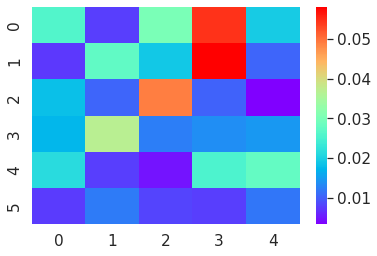

In [70]:
sns.heatmap(global_shap_importance.shapley_importance_class_1.values.reshape(mp.fmap_shape), cmap = 'rainbow')

<AxesSubplot:>

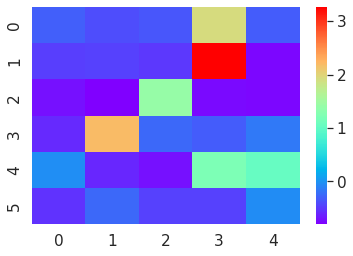

In [75]:
sns.heatmap(global_simp_importance.simply_importance_class_1.values.reshape(mp.fmap_shape), cmap = 'rainbow')

2021-10-03 03:45:58,396 - INFO - [bidd-aggmap] - generate file: ./feature points_30_correlation_umap_scatter
2021-10-03 03:45:58,405 - INFO - [bidd-aggmap] - save html file to ./feature points_30_correlation_umap_scatter
2021-10-03 03:45:58,405 - INFO - [bidd-aggmap] - generate file: ./feature points_30_correlation_umap_mp
2021-10-03 03:45:58,412 - INFO - [bidd-aggmap] - save html file to ./feature points_30_correlation_umap_mp


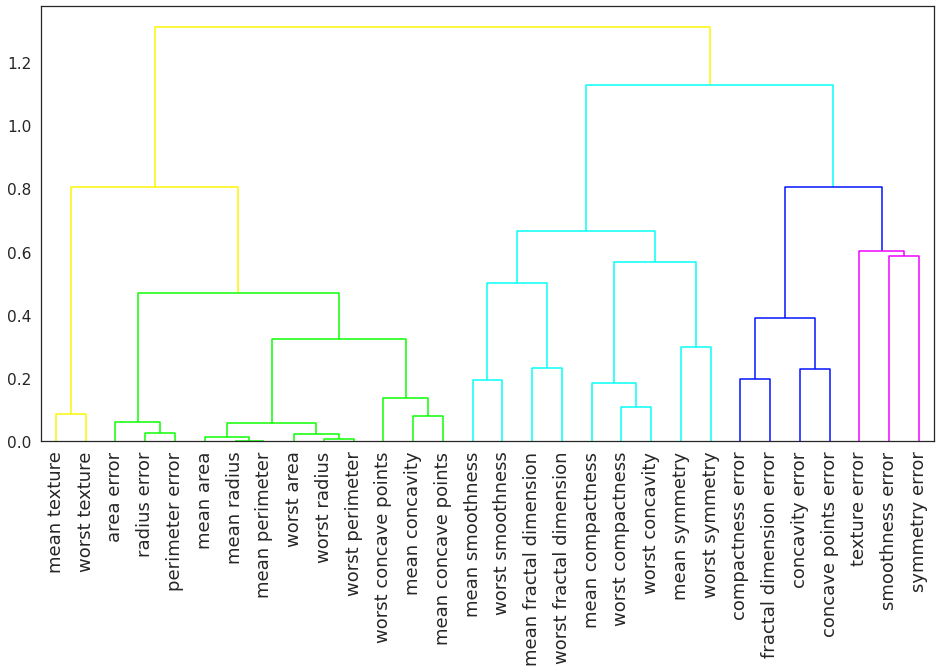

In [77]:
mp.plot_tree()
mp.plot_scatter(enabled_data_labels=True, radius=5)
mp.plot_grid(enabled_data_labels=True,)